#1.Carga de Librerias y Datos


*Se importan los módulos necesarios para trabajar*

In [22]:
#Pandas es utilizado para leer los set de datos
import pandas as pd
#Numpy es utilizado para generar las series de datos a graficar
import numpy as np
import matplotlib.pyplot as plt
#Se importan modulos estadisticos para generar test de hipotesis, entre otros
from sklearn.preprocessing import StandardScaler
#Módulos implementa funciones que evalúan el error de predicción para propósitos específicos
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_squared_error as mse
#Ignorar warnings
import warnings
warnings.filterwarnings("ignore")

#Dividir arreglos o matrices en subconjuntos aleatorios de tren y prueba
from sklearn.model_selection import train_test_split

#Biblioteca de Redes Neuronales
from keras.models import Sequential,model_from_json
from keras.layers import Dropout, GRU, Dense, Activation,Input
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten,GlobalAveragePooling1D
from keras.callbacks import EarlyStopping, ModelCheckpoint

from hyperopt import Trials, STATUS_OK, tpe, hp, fmin, space_eval
from sklearn.model_selection import cross_val_score, KFold, cross_val_predict, TimeSeriesSplit
import time,os

In [23]:
# Para acceder a los archivos del gdrive
from google.colab import drive
drive.mount('/content/gdrive/')



Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [24]:

cd /content/gdrive/MyDrive/Tesis/Datos-2

/content/gdrive/MyDrive/Tesis/Datos-2


Se obtiene conjunto de datos

In [25]:
predictor_variables=pd.read_csv('predictor_variables.csv', index_col='dt')
target_variables=pd.read_csv('target_variables.csv', index_col='dt')
df=pd.read_csv('df_modelo.csv', index_col='dt')

In [26]:
#Setear semilla
np.random.seed(42)
# Ajustar parámetros para reproducibilidad del entrenamiento
#tf.random.set_seed(123)
keras.utils.set_random_seed(123)
tf.config.experimental.enable_op_determinism()

#Separar datos para entrenamiento

In [27]:
#Se separa conjunto en entrenamiento y prueba; sin aleatoriedad
#Dejando un %30 de la data para test
X_train, X_test, Y_train, Y_test = train_test_split(predictor_variables, target_variables, test_size=0.2, shuffle=False)

shape_x_test=X_test.shape
shape_y_test=Y_test.shape

print("Separacion de datos terminada!")

Separacion de datos terminada!


#Resultados

## delete

###Exportar resultados

In [28]:
result_mlp=pd.read_csv('delete.csv')
result_mlp = result_mlp.sort_values(by='MSE', ascending=True)
result_mlp.head(5)


,Unnamed: 0,nameModel,trial_optimizacion_bayesiana,Step_validacion,time,MSE,RMSE,MAE,MAPE
2,2,MLP_CE_1_3_800_40.0_2.0_64.0_0.57_adam_4.68662...,1,3,15.987812,0.400920,0.633183,0.485341,214.517731
4,4,MLP_CE_1_5_800_40.0_2.0_64.0_0.57_adam_4.68662...,1,5,17.208363,0.404636,0.636110,0.479726,217.860504
3,3,MLP_CE_1_4_800_40.0_2.0_64.0_0.57_adam_4.68662...,1,4,13.588538,0.420208,0.648235,0.489579,242.932480
0,0,MLP_CE_1_1_800_40.0_2.0_64.0_0.57_adam_4.68662...,1,1,15.873441,0.465642,0.682380,0.531039,260.345062
1,1,MLP_CE_1_2_800_40.0_2.0_64.0_0.57_adam_4.68662...,1,2,18.759426,0.491067,0.700762,0.553698,280.493134


In [42]:
nombre_archivo=result_mlp['nameModel'].iloc[1]
nombre_archivo

'MLP_CE_1_5_800_40.0_2.0_64.0_0.57_adam_4.6866202578205683e-05'

In [44]:
nombre_json=nombre_archivo+"."+"json"
carpeta_destino = '/content/gdrive/MyDrive/Tesis/Datos-2/delete'
ruta = os.path.join(carpeta_destino, nombre_json)
save_w=nombre_archivo+"."+"h5"
weights_path = os.path.join(carpeta_destino, save_w)

In [45]:
# load json and create model
json_file = open(ruta, 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(weights_path)
print("Loaded model from disk")

# evaluate loaded model on test data
loaded_model.compile(loss='mean_squared_error', optimizer="adam", metrics = [tf.keras.metrics.MeanSquaredError(),
                            tf.keras.metrics.RootMeanSquaredError(),
                            tf.keras.metrics.MeanAbsoluteError(),
                            tf.keras.metrics.MeanAbsolutePercentageError()])


Loaded model from disk


###Grafico de prediccion

In [46]:
#Se realiza prediccion
results = loaded_model.predict(X_test)

9/9 [==============================] - 0s 1ms/step


In [47]:
#Metricas de precision del modelo
score = loaded_model.evaluate(X_test, Y_test, verbose = 0)
print('MSE:', score[1])
print('RMSE:', score[2])
print('MAE:', score[3])
print('MAPE:', score[4])

MSE: 0.38207852840423584
RMSE: 0.6181250214576721
MAE: 0.4668433964252472
MAPE: 379.9557189941406


In [41]:
#Metricas de precision del modelo
score = loaded_model.evaluate(X_test, Y_test, verbose = 0)
print('MSE:', score[1])
print('RMSE:', score[2])
print('MAE:', score[3])
print('MAPE:', score[4])

MSE: 0.37832173705101013
RMSE: 0.6150786280632019
MAE: 0.4726947546005249
MAPE: 363.6231994628906


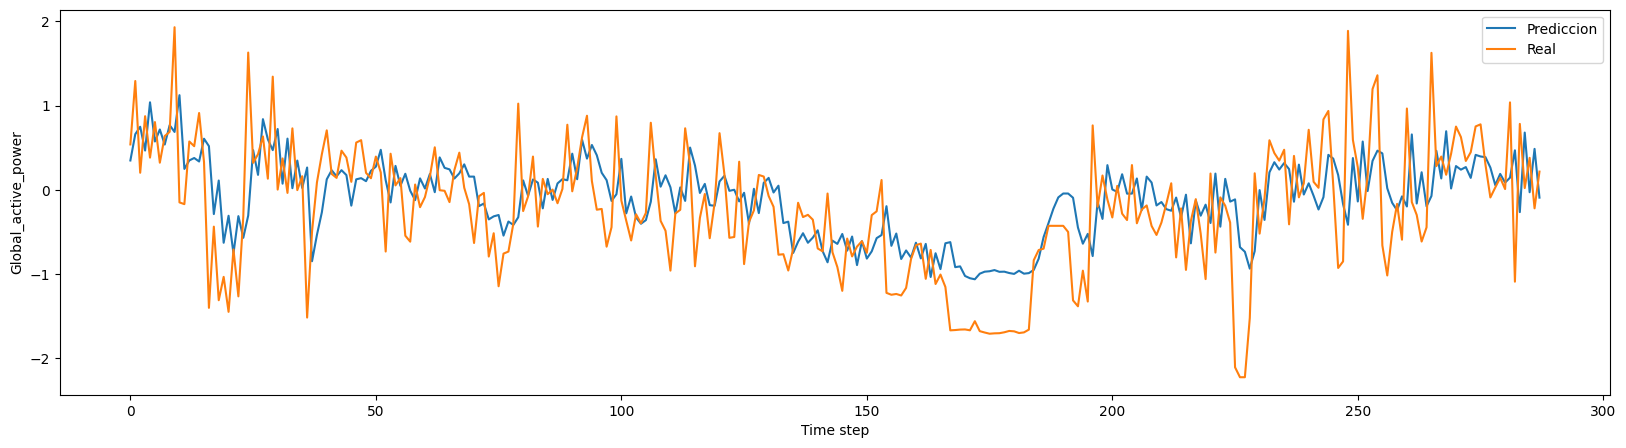

In [34]:
#Grafico de prediccion con el valor real
tiempo=[x for x in range(Y_test.shape[0])]
plt.figure(figsize=(20,5))
plt.plot(tiempo,results)
plt.ylabel('Global_active_power', size=10)
plt.plot(tiempo,Y_test)
plt.xlabel('Time step', size=10)
plt.legend(['Prediccion','Real'])
plt.show()

## MLP

###Exportar resultados

In [ ]:
result_mlp=pd.read_csv('results_MLP_CE.csv')
result_mlp = result_mlp.sort_values(by='MSE', ascending=True)
result_mlp.head(5)


,Unnamed: 0,nameModel,trial_optimizacion_bayesiana,Step_validacion,time,MSE,RMSE,MAE,MAPE
488,488,MLP_CE_98_4_800_70.0_3.0_416.0_0.67_adam_2.437...,98,4,5.377616,0.375814,0.613037,0.460232,203.494705
68,68,MLP_CE_14_4_800_40.0_3.0_320.0_0.52_adam_1.691...,14,4,6.487561,0.379791,0.616272,0.465164,213.475876
489,489,MLP_CE_98_5_800_70.0_3.0_416.0_0.67_adam_2.437...,98,5,9.411418,0.380050,0.616482,0.460444,190.512939
354,354,MLP_CE_71_5_800_30.0_3.0_192.0_0.67_adam_3.812...,71,5,9.018559,0.380055,0.616486,0.465961,182.855652
322,322,MLP_CE_65_3_800_30.0_3.0_160.0_0.42_adam_1.761...,65,3,10.069403,0.382736,0.618656,0.466213,194.553406


In [ ]:
nombre_archivo=result_mlp['nameModel'].iloc[0]
nombre_archivo

'MLP_CE_98_4_800_70.0_3.0_416.0_0.67_adam_2.4379520373693085e-05'

In [ ]:
nombre_json=nombre_archivo+"."+"json"
carpeta_destino = '/content/gdrive/MyDrive/Tesis/Datos-2/result_MLP'
ruta = os.path.join(carpeta_destino, nombre_json)
save_w=nombre_archivo+"."+"h5"
weights_path = os.path.join(carpeta_destino, save_w)

In [ ]:
# load json and create model
json_file = open(ruta, 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(weights_path)
print("Loaded model from disk")

# evaluate loaded model on test data
loaded_model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=2.4379520373693085e-05), metrics = [tf.keras.metrics.MeanSquaredError(),
                            tf.keras.metrics.RootMeanSquaredError(),
                            tf.keras.metrics.MeanAbsoluteError(),
                            tf.keras.metrics.MeanAbsolutePercentageError()])


Loaded model from disk


###Grafico de prediccion

In [ ]:
#Se realiza prediccion
results = loaded_model.predict(X_test)

9/9 [==============================] - 0s 3ms/step


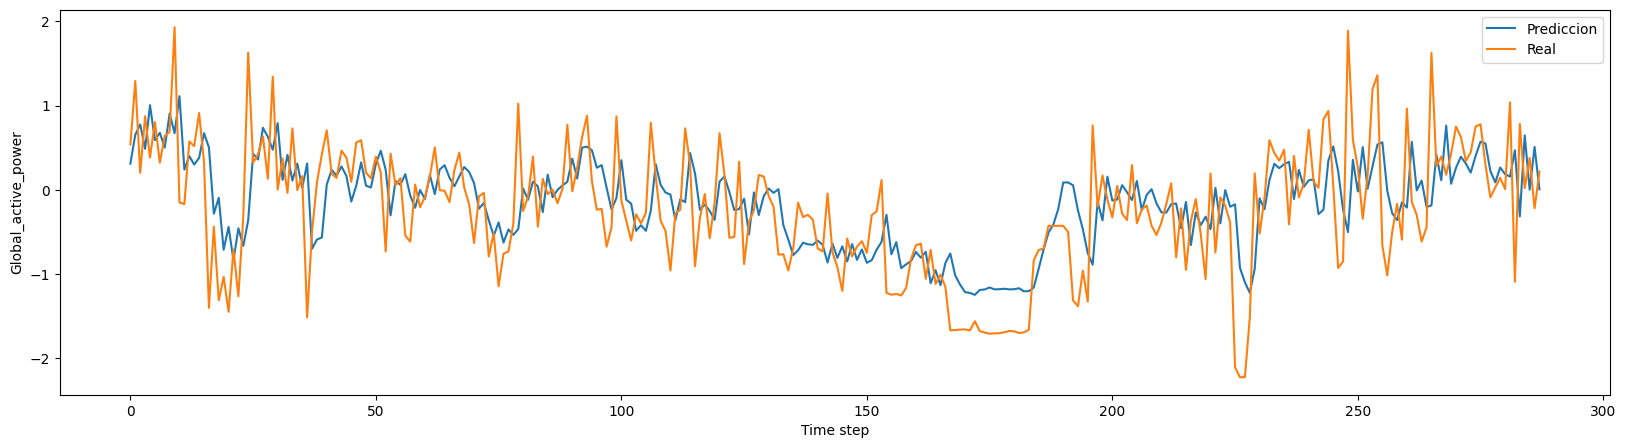

In [ ]:
#Grafico de prediccion con el valor real
tiempo=[x for x in range(Y_test.shape[0])]
plt.figure(figsize=(20,5))
plt.plot(tiempo,results)
plt.ylabel('Global_active_power', size=10)
plt.plot(tiempo,Y_test)
plt.xlabel('Time step', size=10)
plt.legend(['Prediccion','Real'])
plt.show()

## CNN

###Exportar resultados

In [ ]:
result_cnn=pd.read_csv('results_CNN_CE.csv')
result_cnn = result_cnn.sort_values(by='MSE', ascending=True)
result_cnn.head(5)


,Unnamed: 0,nameModel,trial_optimizacion_bayesiana,Step_validacion,time,MSE,RMSE,MAE,MAPE
173,173,CNN_CE_800_60.0_2.0_100.0_0.63_adam_3.21510030...,35,4,7.002579,0.372284,0.610150,0.447380,193.632339
343,343,CNN_CE_800_60.0_2.0_200.0_0.64_adam_2.54716769...,69,4,11.349024,0.372287,0.610153,0.453491,194.921432
279,279,CNN_CE_800_70.0_2.0_100.0_0.62_adam_1.53838502...,56,5,16.170364,0.372849,0.610613,0.448964,188.639374
394,394,CNN_CE_800_20.0_2.0_100.0_0.67_adam_4.88524469...,79,5,12.009378,0.373540,0.611179,0.450430,187.399948
333,333,CNN_CE_800_60.0_2.0_100.0_0.7_adam_2.909277765...,67,4,17.459790,0.375022,0.612391,0.447587,187.844406


In [ ]:
nombre_archivo=result_cnn['nameModel'].iloc[0]
nombre_archivo

'CNN_CE_800_60.0_2.0_100.0_0.63_adam_3.2151003059981485e-05_2_192.0'

In [ ]:
nombre_json=nombre_archivo+"."+"json"
carpeta_destino = '/content/gdrive/MyDrive/Tesis/Datos-2/result_CNN'
ruta = os.path.join(carpeta_destino, nombre_json)
save_w=nombre_archivo+"."+"h5"
weights_path = os.path.join(carpeta_destino, save_w)

In [ ]:
# load json and create model
json_file = open(ruta, 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(weights_path)
print("Loaded model from disk")

# evaluate loaded model on test data
loaded_model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=3.2151003059981485e-05), metrics = [tf.keras.metrics.MeanSquaredError(),
                            tf.keras.metrics.RootMeanSquaredError(),
                            tf.keras.metrics.MeanAbsoluteError(),
                            tf.keras.metrics.MeanAbsolutePercentageError()])


Loaded model from disk


###Grafico de prediccion

In [ ]:
#Se da formato de entradas como: Un tensor 3D con la forma [batch, timesteps, feature]
X_train_cnn=np.array(X_train)
X_train_cnn = X_train_cnn.reshape((X_train_cnn.shape[0],X_train_cnn.shape[1],1))

Y_train_cnn=np.array(Y_train)
Y_train_cnn = Y_train_cnn.reshape((Y_train_cnn.shape[0],Y_train_cnn.shape[1],1))

X_test_cnn=np.array(X_test)
X_test_cnn = X_test_cnn.reshape((X_test_cnn.shape[0],X_test_cnn.shape[1],1))

Y_test_cnn=np.array(Y_test)
Y_test_cnn = Y_test_cnn.reshape((Y_test_cnn.shape[0], Y_test_cnn.shape[1],1))

In [ ]:
#Se realiza prediccion
results = loaded_model.predict(X_test_cnn)

9/9 [==============================] - 0s 3ms/step


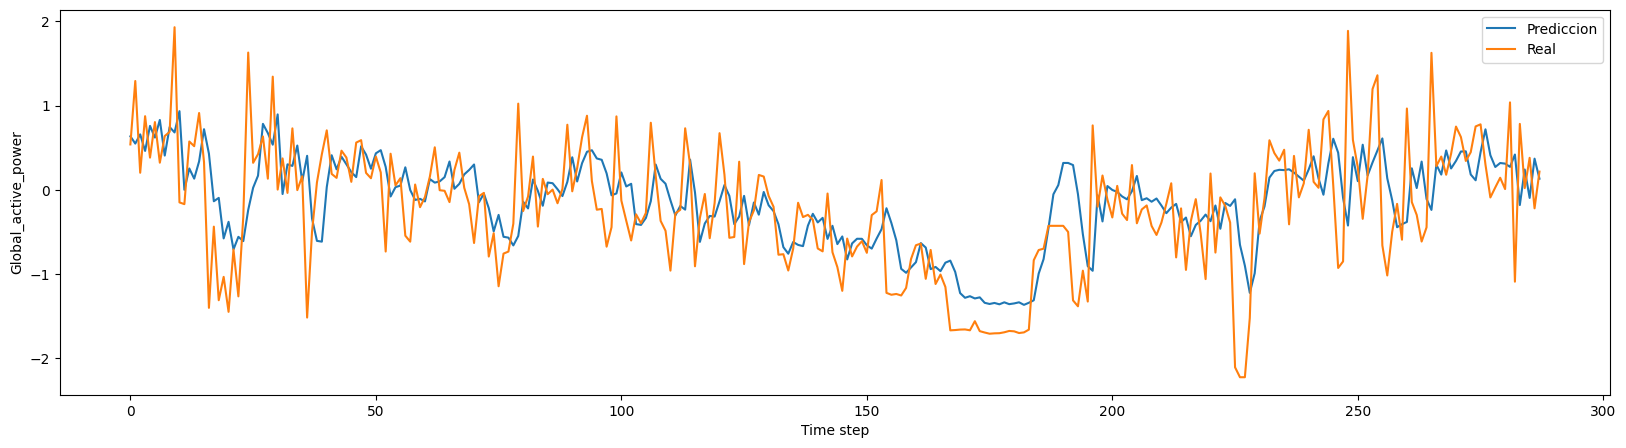

In [ ]:
#Grafico de prediccion con el valor real
tiempo=[x for x in range(Y_test.shape[0])]
plt.figure(figsize=(20,5))
plt.plot(tiempo,results)
plt.ylabel('Global_active_power', size=10)
plt.plot(tiempo,Y_test)
plt.xlabel('Time step', size=10)
plt.legend(['Prediccion','Real'])
plt.show()

##GRU

###Exportar resultados

In [ ]:
result_gru=pd.read_csv('results_GRU_CE.csv')
result_gru = result_gru.sort_values(by='MSE', ascending=True)
result_gru.head(5)


,Unnamed: 0,nameModel,trial_optimizacion_bayesiana,Step_validacion,time,MSE,RMSE,MAE,MAPE
334,334,GRU_CE_67_5_800_10.0_3.0_500.0_0.49_adam_0.000...,67,5,27.252400,0.358205,0.598502,0.440844,194.151001
424,424,GRU_CE_85_5_800_10.0_2.0_800.0_0.54_adam_0.000...,85,5,20.559656,0.362767,0.602301,0.443280,186.456909
484,484,GRU_CE_97_5_800_10.0_3.0_400.0_0.47_adam_0.000...,97,5,25.128468,0.369431,0.607808,0.456008,192.567245
64,64,GRU_CE_13_5_800_50.0_2.0_800.0_0.63_adam_0.000...,13,5,9.445666,0.373207,0.610907,0.448703,204.133591
199,199,GRU_CE_40_5_800_20.0_2.0_540.0_0.7_adam_0.0001...,40,5,17.485842,0.374655,0.612090,0.455858,204.192612


In [ ]:
nombre_archivo=result_gru['nameModel'].iloc[0]
nombre_archivo

'GRU_CE_67_5_800_10.0_3.0_500.0_0.49_adam_0.0004874858675338587'

In [ ]:
nombre_json=nombre_archivo+"."+"json"
carpeta_destino = '/content/gdrive/MyDrive/Tesis/Datos-2/result_GRU'
ruta = os.path.join(carpeta_destino, nombre_json)
save_w=nombre_archivo+"."+"h5"
weights_path = os.path.join(carpeta_destino, save_w)

In [ ]:
# load json and create model
json_file = open(ruta, 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(weights_path)
print("Loaded model from disk")

# evaluate loaded model on test data
loaded_model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.0004874858675338587), metrics = [tf.keras.metrics.MeanSquaredError(),
                            tf.keras.metrics.RootMeanSquaredError(),
                            tf.keras.metrics.MeanAbsoluteError(),
                            tf.keras.metrics.MeanAbsolutePercentageError()])


Loaded model from disk


###Grafico de prediccion

In [ ]:
#Se da formato de entradas como: Un tensor 3D con la forma [batch, timesteps, feature]
X_train=np.array(X_train)
X_train = X_train.reshape((X_train.shape[0],1,X_train.shape[1]))

Y_train_s=np.array(Y_train)
Y_train_s = Y_train_s.reshape((Y_train_s.shape[0],1,Y_train_s.shape[1]))

X_test=np.array(X_test)
X_test = X_test.reshape((X_test.shape[0],1,X_test.shape[1]))

Y_test=np.array(Y_test)
Y_test = Y_test.reshape((Y_test.shape[0], 1, Y_test.shape[1]))

In [ ]:
#Se realiza prediccion
results = loaded_model.predict(X_test)

9/9 [==============================] - 1s 17ms/step


In [ ]:
results = results.reshape(shape_y_test)
y_grafico = Y_test.reshape(shape_y_test)

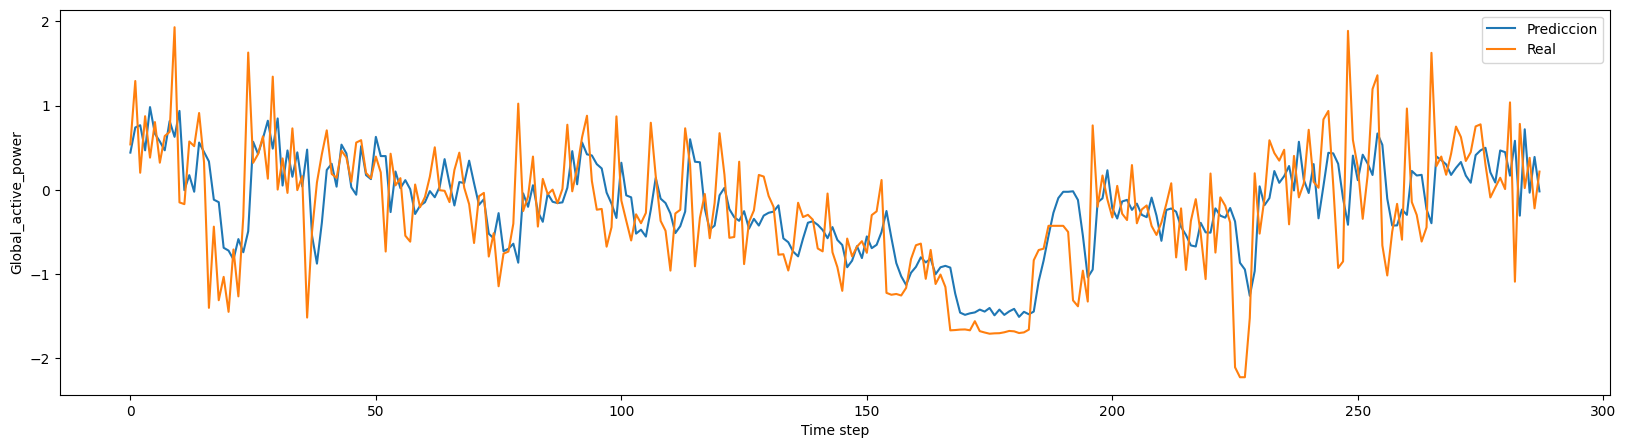

In [ ]:
#Grafico de prediccion con el valor real
tiempo=[x for x in range(y_grafico.shape[0])]
plt.figure(figsize=(20,5))
plt.plot(tiempo,results)
plt.ylabel('Global_active_power', size=10)
plt.plot(tiempo,y_grafico)
plt.xlabel('Time step', size=10)
plt.legend(['Prediccion','Real'])
plt.show()

##LSTM

###Exportar resultados

In [ ]:
#Se da formato de entradas como: Un tensor 3D con la forma [batch, timesteps, feature]
X_train=np.array(X_train)
X_train = X_train.reshape((X_train.shape[0],1,X_train.shape[1]))

Y_train_s=np.array(Y_train)
Y_train_s = Y_train_s.reshape((Y_train_s.shape[0],1,Y_train_s.shape[1]))

X_test=np.array(X_test)
X_test = X_test.reshape((X_test.shape[0],1,X_test.shape[1]))

Y_test=np.array(Y_test)
Y_test = Y_test.reshape((Y_test.shape[0], 1, Y_test.shape[1]))

In [ ]:
result_lstm=pd.read_csv('results_LSTM_CE.csv')
result_lstm = result_lstm.sort_values(by='MSE', ascending=True)
result_lstm.head(5)


,Unnamed: 0,nameModel,trial_optimizacion_bayesiana,Step_validacion,time,MSE,RMSE,MAE,MAPE
139,139,LSTM_CE_800_10.0_1.0_680.0_0.52_adam_3.1458576...,28,5,36.681360,0.378168,0.614954,0.455236,220.871017
319,319,LSTM_CE_800_10.0_1.0_640.0_0.42_adam_4.4268419...,64,5,28.392772,0.379389,0.615946,0.456227,220.155869
299,299,LSTM_CE_800_20.0_1.0_780.0_0.68_adam_4.2855902...,60,5,23.493317,0.380622,0.616946,0.457438,223.087753
94,94,LSTM_CE_800_30.0_1.0_620.0_0.55_adam_3.4341560...,19,5,20.831620,0.380932,0.617197,0.456960,224.679672
499,499,LSTM_CE_800_20.0_2.0_480.0_0.54_adam_1.6602774...,100,5,51.668610,0.380971,0.617228,0.457549,221.807846


In [ ]:
nombre_archivo=result_lstm['nameModel'].iloc[0]
nombre_archivo

'LSTM_CE_800_10.0_1.0_680.0_0.52_adam_3.1458576754462924e-05'

In [ ]:
nombre_archivo='LSTM_CE_28_5_800_10.0_1.0_680.0_0.52_adam_3.1458576754462924e-05'
nombre_json=nombre_archivo+"."+"json"
carpeta_destino = '/content/gdrive/MyDrive/Tesis/Datos-2/result_LSTM'
ruta = os.path.join(carpeta_destino, nombre_json)
save_w=nombre_archivo+"."+"h5"
weights_path = os.path.join(carpeta_destino, save_w)

In [ ]:
# load json and create model
json_file = open(ruta, 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(weights_path)
print("Loaded model from disk")

# evaluate loaded model on test data
loaded_model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=3.1458576754462924e-05), metrics = [tf.keras.metrics.MeanSquaredError(),
                            tf.keras.metrics.RootMeanSquaredError(),
                            tf.keras.metrics.MeanAbsoluteError(),
                            tf.keras.metrics.MeanAbsolutePercentageError()])


Loaded model from disk


###Grafico de prediccion

In [ ]:
#Se realiza prediccion
results = loaded_model.predict(X_test)

9/9 [==============================] - 0s 6ms/step


In [ ]:
results = results.reshape(shape_y_test)
y_grafico = Y_test.reshape(shape_y_test)

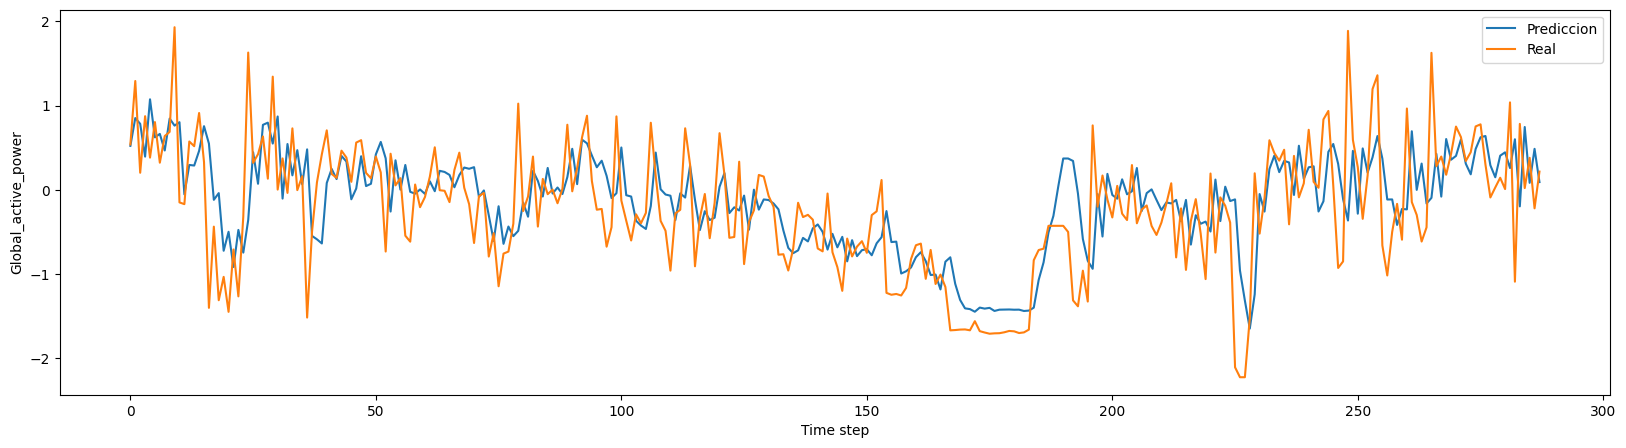

In [ ]:
#Grafico de prediccion con el valor real
tiempo=[x for x in range(y_grafico.shape[0])]
plt.figure(figsize=(20,5))
plt.plot(tiempo,results)
plt.ylabel('Global_active_power', size=10)
plt.plot(tiempo,y_grafico)
plt.xlabel('Time step', size=10)
plt.legend(['Prediccion','Real'])
plt.show()

##Transformer

In [ ]:
32000/8500

3.764705882352941

###Exportar resultados

In [ ]:
result_transformer=pd.read_csv('results_Transformer_CE.csv')
result_transformer = result_transformer.sort_values(by='MSE', ascending=True)
result_transformer.head(5)


,index,nameModel,trial_optimizacion_bayesiana,Step_validacion,time,MSE,RMSE,MAE,MAPE
0,439,Transformer_CE_800_40.0_128.0_6.0_0.64_160.0_3...,88,5,47.148076,0.370745,0.608889,0.442792,215.380447
1,159,Transformer_CE_800_20.0_192.0_6.0_0.59_128.0_4...,32,5,49.049351,0.372243,0.610117,0.453836,239.374893
2,259,Transformer_CE_800_50.0_128.0_5.0_0.47_160.0_2...,52,5,76.609337,0.374506,0.611969,0.451261,210.443329
3,494,Transformer_CE_800_40.0_128.0_6.0_0.61_160.0_3...,99,5,69.508075,0.374999,0.612372,0.450840,214.465591
4,299,Transformer_CE_800_10.0_160.0_6.0_0.59_96.0_4....,60,5,109.001675,0.377282,0.614233,0.453981,207.757339


In [ ]:
nombre_archivo=result_transformer['nameModel'].iloc[0]
nombre_archivo

'Transformer_CE_800_40.0_128.0_6.0_0.64_160.0_3.6125042299943215e-05'

In [ ]:
nombre_json=nombre_archivo+"."+"json"
carpeta_destino = '/content/gdrive/MyDrive/Tesis/Datos-2/result_Transformer'
ruta = os.path.join(carpeta_destino, nombre_json)
save_w=nombre_archivo+"."+"h5"
weights_path = os.path.join(carpeta_destino, save_w)

In [ ]:
# load json and create model
json_file = open(ruta, 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(weights_path)
print("Loaded model from disk")

# evaluate loaded model on test data
loaded_model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=3.6125042299943215e-05), metrics = [tf.keras.metrics.MeanSquaredError(),
                            tf.keras.metrics.RootMeanSquaredError(),
                            tf.keras.metrics.MeanAbsoluteError(),
                            tf.keras.metrics.MeanAbsolutePercentageError()])


Loaded model from disk


###Grafico de prediccion

In [ ]:
#Se realiza prediccion
results = loaded_model.predict(X_test)

9/9 [==============================] - 0s 4ms/step


In [ ]:
results = results.reshape(shape_y_test)
y_grafico = Y_test.reshape(shape_y_test)

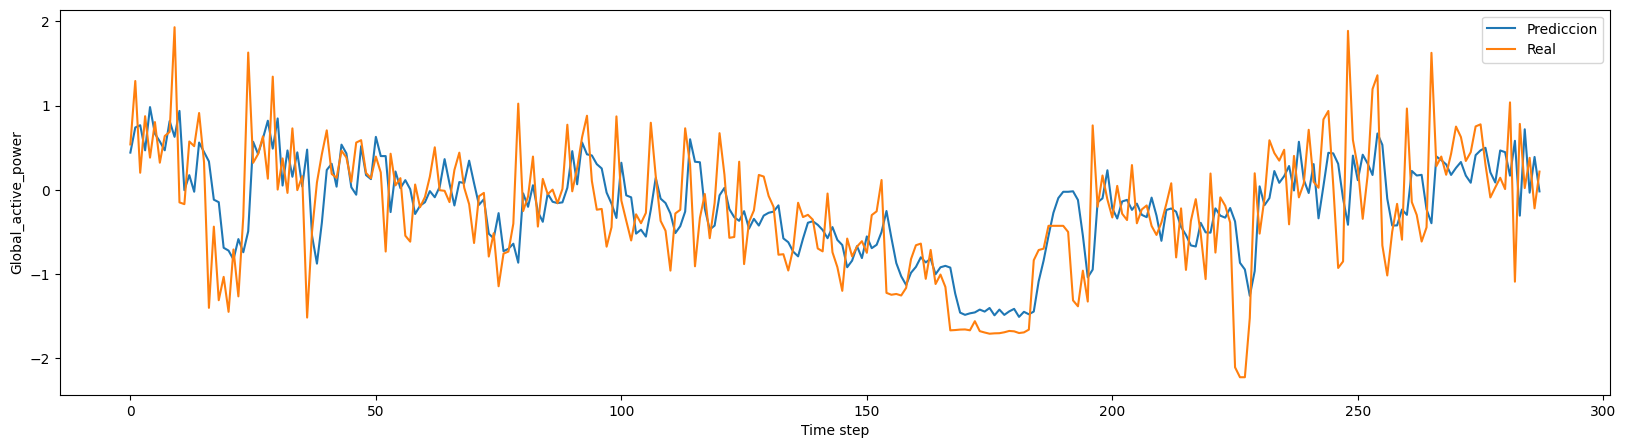

In [ ]:
#Grafico de prediccion con el valor real
tiempo=[x for x in range(y_grafico.shape[0])]
plt.figure(figsize=(20,5))
plt.plot(tiempo,results)
plt.ylabel('Global_active_power', size=10)
plt.plot(tiempo,y_grafico)
plt.xlabel('Time step', size=10)
plt.legend(['Prediccion','Real'])
plt.show()